# Fine_tune_SegFormer_on_custom_dataset con AUMENTACIÓN DE DATOS

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import numpy as np
from transformers import SegformerImageProcessor

1. Cargamos DATOS

In [3]:
import torch

if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("❌ No hay GPU disponible.")



✅ GPU disponible: NVIDIA GeForce RTX 3060


2. Cargamos clase

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import numpy as np
import albumentations as A

class CancerSegmentationDataset(Dataset):
    def __init__(self, base_path, image_processor, indices=None, train=True, image_size=256):
        """
        Args:
            base_path (str): Ruta base de los datos.
            image_processor: SegformerImageProcessor para codificación.
            indices (list, optional): Lista de índices para usar un subconjunto del dataset.
            train (bool): Define si se aplican augmentations de entrenamiento.
            image_size (int): Tamaño al que se redimensionan imágenes y máscaras.
        """
        self.base_path = base_path
        self.image_processor = image_processor
        self.train = train
        self.image_size = image_size
        self.image_paths = []
        self.mask_paths = []

        # --- Recorrer carpetas y cargar paths ---
        for folder_name in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder_name)
            if os.path.isdir(folder_path):
                images_dir = os.path.join(folder_path, "images")
                masks_dir = os.path.join(folder_path, "masks")
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    images = sorted(os.listdir(images_dir))
                    masks = sorted(os.listdir(masks_dir))
                    for img_name in images:
                        img_base = os.path.splitext(img_name)[0]
                        mask_name = img_base + "_1.jpg"
                        if mask_name in masks:
                            self.image_paths.append(os.path.join(images_dir, img_name))
                            self.mask_paths.append(os.path.join(masks_dir, mask_name))

        # --- Aplicar subconjunto de indices si se pasa ---
        if indices is not None:
            self.image_paths = [self.image_paths[i] for i in indices]
            self.mask_paths = [self.mask_paths[i] for i in indices]

        # --- Transformaciones ---
        if self.train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomBrightnessContrast(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.MotionBlur(blur_limit=3, p=0.2),
                A.GridDistortion(p=0.2),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
                A.Resize(height=self.image_size, width=self.image_size)
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=self.image_size, width=self.image_size)
            ])

    def __len__(self):
        return len(self.image_paths)

    def load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        else:
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype(np.uint8)
        return mask

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = self.load_mask(self.mask_paths[idx])

        # Redimensionar (seguridad)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask'].astype(np.int64)

        # Codificación con image_processor
        encoded = self.image_processor(images=image, segmentation_maps=mask, return_tensors="pt")
        for k, v in encoded.items():
            encoded[k] = v.squeeze(0)

        return encoded





In [ ]:
from transformers import SegformerImageProcessor
import numpy as np

root_dir = "/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles"
image_processor = SegformerImageProcessor(reduce_labels=False)

full_dataset = CancerSegmentationDataset(base_path=root_dir, image_processor=image_processor, train=True, image_size=512)
total_samples = len(full_dataset)


indices = np.arange(total_samples)
np.random.shuffle(indices)

train_end = int(0.8 * total_samples)
val_end   = int(0.9 * total_samples)

train_indices = indices[:train_end]
val_indices   = indices[train_end:val_end]
test_indices  = indices[val_end:]

train_dataset = CancerSegmentationDataset(base_path=root_dir, image_processor=image_processor,
                                          indices=train_indices, train=True, image_size=512)

valid_dataset = CancerSegmentationDataset(base_path=root_dir, image_processor=image_processor,
                                          indices=val_indices, train=False, image_size=512)

test_dataset = CancerSegmentationDataset(base_path=root_dir, image_processor=image_processor,
                                         indices=test_indices, train=False, image_size=512)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))


Train samples: 257
Validation samples: 32
Test samples: 33


/home/anna/.venvs/venv_finetune/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1398375/379356905.py:53: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/tmp/ipykernel_1398375/379356905.py:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [6]:
print(f"✅ Número de muestras de entrenamiento: {len(train_dataset)}")
print(f"✅ Número de muestras de validación: {len(valid_dataset)}")
print(f"✅ Número de muestras de test: {len(test_dataset)}")


✅ Número de muestras de entrenamiento: 257
✅ Número de muestras de validación: 32
✅ Número de muestras de test: 33


In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1])

3. DataLoader

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=4, shuffle=False)


In [14]:
batch = next(iter(train_dataloader))

In [15]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [16]:
batch["labels"].shape

torch.Size([4, 512, 512])

In [17]:
mask = (batch["labels"] != 0)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [18]:
batch["labels"][mask]

tensor([1, 1, 1,  ..., 1, 1, 1])

4. Modelo

In [19]:
id2label = {
    0: "background",
    1: "tumor"
}
label2id = {v: k for k, v in id2label.items()}


In [20]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",  #binario
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
image_processor.do_reduce_labels

False

In [23]:
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=1e-2)

best_val_dice = 0.0
history = {
    "train_loss": [],
    "train_dice": [],
    "val_dice": [],
}

def compute_dice(preds, targets, smooth=1e-6):
    preds = preds.flatten()
    targets = targets.flatten()
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

total_start_time = time.time()

for epoch in range(100):
    print(f"\n🔁 Epoch {epoch+1}/100")
    epoch_start_time = time.time()
    
    # --- Entrenamiento ---
    model.train()
    train_loss = 0.0
    train_dice_scores = []

    for batch in tqdm(train_dataloader, desc="Entrenamiento"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)
            mask = labels != 255
            dice = compute_dice(predicted[mask], labels[mask])
            train_dice_scores.append(dice)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_dice = sum(train_dice_scores) / len(train_dice_scores)

    history["train_loss"].append(avg_train_loss)
    history["train_dice"].append(avg_train_dice)

    print(f"📊 Train Loss: {avg_train_loss:.4f} | Train Dice: {avg_train_dice:.4f}")

    # --- Validación ---
    model.eval()
    val_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validación"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)
            mask = labels != 255
            dice = compute_dice(predicted[mask], labels[mask])
            val_dice_scores.append(dice)

    avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)
    history["val_dice"].append(avg_val_dice)

    print(f"✅ Val Dice: {avg_val_dice:.4f}")

    # Guardar mejor modelo
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 Saved new best model with Dice: {best_val_dice:.4f}")

    epoch_duration = time.time() - epoch_start_time
    print(f"🕒 Duración de la época: {epoch_duration:.2f} segundos")

# --- Evaluación final en train, valid y test ---
model.eval()
def evaluate_dice(dataloader):
    dice_scores = []
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            logits = model(pixel_values=pixel_values).logits
            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)
            mask = labels != 255
            dice = compute_dice(predicted[mask], labels[mask])
            dice_scores.append(dice)
    return sum(dice_scores) / len(dice_scores)

final_train_dice = evaluate_dice(train_dataloader)
final_val_dice   = evaluate_dice(valid_dataloader)
final_test_dice  = evaluate_dice(test_dataloader)

total_duration = time.time() - total_start_time
print(f"\n🏁 Entrenamiento completo en {total_duration/60:.2f} min ({total_duration:.2f} s)")
print(f"🎯 Dice final - Train: {final_train_dice:.4f}, Val: {final_val_dice:.4f}, Test: {final_test_dice:.4f}")



🔁 Epoch 1/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


📊 Train Loss: 0.3640 | Train Dice: 0.4884


Validación: 100%|██████████| 8/8 [00:00<00:00, 13.56it/s]


✅ Val Dice: 0.6432
💾 Saved new best model with Dice: 0.6432
🕒 Duración de la época: 13.01 segundos

🔁 Epoch 2/100


Entrenamiento: 100%|██████████| 64/64 [00:13<00:00,  4.84it/s]


📊 Train Loss: 0.2603 | Train Dice: 0.5162


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]


✅ Val Dice: 0.6786
💾 Saved new best model with Dice: 0.6786
🕒 Duración de la época: 13.82 segundos

🔁 Epoch 3/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]


📊 Train Loss: 0.2147 | Train Dice: 0.5433


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]


✅ Val Dice: 0.6042
🕒 Duración de la época: 12.98 segundos

🔁 Epoch 4/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  4.95it/s]


📊 Train Loss: 0.1871 | Train Dice: 0.5766


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]


✅ Val Dice: 0.7089
💾 Saved new best model with Dice: 0.7089
🕒 Duración de la época: 13.53 segundos

🔁 Epoch 5/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


📊 Train Loss: 0.1657 | Train Dice: 0.6222


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.37it/s]


✅ Val Dice: 0.7254
💾 Saved new best model with Dice: 0.7254
🕒 Duración de la época: 13.53 segundos

🔁 Epoch 6/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]


📊 Train Loss: 0.1603 | Train Dice: 0.6189


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s]


✅ Val Dice: 0.7178
🕒 Duración de la época: 13.08 segundos

🔁 Epoch 7/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


📊 Train Loss: 0.1448 | Train Dice: 0.6621


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.47it/s]


✅ Val Dice: 0.7393
💾 Saved new best model with Dice: 0.7393
🕒 Duración de la época: 13.21 segundos

🔁 Epoch 8/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


📊 Train Loss: 0.1407 | Train Dice: 0.6672


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.66it/s]


✅ Val Dice: 0.7418
💾 Saved new best model with Dice: 0.7418
🕒 Duración de la época: 12.86 segundos

🔁 Epoch 9/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


📊 Train Loss: 0.1347 | Train Dice: 0.6736


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.55it/s]


✅ Val Dice: 0.7037
🕒 Duración de la época: 13.22 segundos

🔁 Epoch 10/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


📊 Train Loss: 0.1327 | Train Dice: 0.6806


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.55it/s]


✅ Val Dice: 0.7318
🕒 Duración de la época: 13.31 segundos

🔁 Epoch 11/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]


📊 Train Loss: 0.1308 | Train Dice: 0.6708


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.67it/s]


✅ Val Dice: 0.7388
🕒 Duración de la época: 13.13 segundos

🔁 Epoch 12/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]


📊 Train Loss: 0.1195 | Train Dice: 0.7244


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.42it/s]


✅ Val Dice: 0.7472
💾 Saved new best model with Dice: 0.7472
🕒 Duración de la época: 13.05 segundos

🔁 Epoch 13/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


📊 Train Loss: 0.1111 | Train Dice: 0.7388


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


✅ Val Dice: 0.7039
🕒 Duración de la época: 13.17 segundos

🔁 Epoch 14/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


📊 Train Loss: 0.1203 | Train Dice: 0.7144


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.51it/s]


✅ Val Dice: 0.7517
💾 Saved new best model with Dice: 0.7517
🕒 Duración de la época: 13.27 segundos

🔁 Epoch 15/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


📊 Train Loss: 0.1121 | Train Dice: 0.7333


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.40it/s]


✅ Val Dice: 0.7507
🕒 Duración de la época: 13.15 segundos

🔁 Epoch 16/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


📊 Train Loss: 0.1160 | Train Dice: 0.7134


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.33it/s]


✅ Val Dice: 0.7442
🕒 Duración de la época: 13.26 segundos

🔁 Epoch 17/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


📊 Train Loss: 0.1101 | Train Dice: 0.7451


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


✅ Val Dice: 0.7493
🕒 Duración de la época: 12.82 segundos

🔁 Epoch 18/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


📊 Train Loss: 0.1025 | Train Dice: 0.7577


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


✅ Val Dice: 0.7485
🕒 Duración de la época: 13.51 segundos

🔁 Epoch 19/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


📊 Train Loss: 0.1048 | Train Dice: 0.7484


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


✅ Val Dice: 0.7680
💾 Saved new best model with Dice: 0.7680
🕒 Duración de la época: 13.28 segundos

🔁 Epoch 20/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


📊 Train Loss: 0.1005 | Train Dice: 0.7650


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]


✅ Val Dice: 0.7662
🕒 Duración de la época: 13.34 segundos

🔁 Epoch 21/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


📊 Train Loss: 0.0964 | Train Dice: 0.7720


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.30it/s]


✅ Val Dice: 0.7098
🕒 Duración de la época: 12.94 segundos

🔁 Epoch 22/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]


📊 Train Loss: 0.0960 | Train Dice: 0.7808


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


✅ Val Dice: 0.7551
🕒 Duración de la época: 12.97 segundos

🔁 Epoch 23/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]


📊 Train Loss: 0.0971 | Train Dice: 0.7663


Validación: 100%|██████████| 8/8 [00:00<00:00, 13.48it/s]


✅ Val Dice: 0.7661
🕒 Duración de la época: 13.13 segundos

🔁 Epoch 24/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.71it/s]


📊 Train Loss: 0.0933 | Train Dice: 0.7777


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


✅ Val Dice: 0.7665
🕒 Duración de la época: 11.72 segundos

🔁 Epoch 25/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.0908 | Train Dice: 0.7863


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


✅ Val Dice: 0.7596
🕒 Duración de la época: 12.25 segundos

🔁 Epoch 26/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.45it/s]


📊 Train Loss: 0.0956 | Train Dice: 0.7752


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


✅ Val Dice: 0.7636
🕒 Duración de la época: 12.25 segundos

🔁 Epoch 27/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]


📊 Train Loss: 0.0891 | Train Dice: 0.7896


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


✅ Val Dice: 0.7662
🕒 Duración de la época: 12.71 segundos

🔁 Epoch 28/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.33it/s]


📊 Train Loss: 0.0882 | Train Dice: 0.7913


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


✅ Val Dice: 0.7531
🕒 Duración de la época: 12.52 segundos

🔁 Epoch 29/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.64it/s]


📊 Train Loss: 0.0930 | Train Dice: 0.7680


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.64it/s]


✅ Val Dice: 0.7707
💾 Saved new best model with Dice: 0.7707
🕒 Duración de la época: 11.88 segundos

🔁 Epoch 30/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s]


📊 Train Loss: 0.0836 | Train Dice: 0.8055


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.73it/s]


✅ Val Dice: 0.7723
💾 Saved new best model with Dice: 0.7723
🕒 Duración de la época: 12.56 segundos

🔁 Epoch 31/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.42it/s]


📊 Train Loss: 0.0856 | Train Dice: 0.7920


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.61it/s]


✅ Val Dice: 0.7749
💾 Saved new best model with Dice: 0.7749
🕒 Duración de la época: 12.35 segundos

🔁 Epoch 32/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.58it/s]


📊 Train Loss: 0.0912 | Train Dice: 0.7806


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.71it/s]


✅ Val Dice: 0.7773
💾 Saved new best model with Dice: 0.7773
🕒 Duración de la época: 12.01 segundos

🔁 Epoch 33/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0834 | Train Dice: 0.8015


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.35it/s]


✅ Val Dice: 0.7857
💾 Saved new best model with Dice: 0.7857
🕒 Duración de la época: 12.31 segundos

🔁 Epoch 34/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.57it/s]


📊 Train Loss: 0.0769 | Train Dice: 0.8165


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


✅ Val Dice: 0.7708
🕒 Duración de la época: 12.01 segundos

🔁 Epoch 35/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]


📊 Train Loss: 0.0760 | Train Dice: 0.8215


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


✅ Val Dice: 0.7817
🕒 Duración de la época: 12.97 segundos

🔁 Epoch 36/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.82it/s]


📊 Train Loss: 0.0795 | Train Dice: 0.8137


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


✅ Val Dice: 0.7739
🕒 Duración de la época: 11.52 segundos

🔁 Epoch 37/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.38it/s]


📊 Train Loss: 0.0836 | Train Dice: 0.7978


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.42it/s]


✅ Val Dice: 0.7499
🕒 Duración de la época: 12.43 segundos

🔁 Epoch 38/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.30it/s]


📊 Train Loss: 0.0821 | Train Dice: 0.8098


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]


✅ Val Dice: 0.7502
🕒 Duración de la época: 12.59 segundos

🔁 Epoch 39/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.35it/s]


📊 Train Loss: 0.0817 | Train Dice: 0.8049


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.40it/s]


✅ Val Dice: 0.7546
🕒 Duración de la época: 12.48 segundos

🔁 Epoch 40/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.34it/s]


📊 Train Loss: 0.0751 | Train Dice: 0.8233


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.50it/s]


✅ Val Dice: 0.7611
🕒 Duración de la época: 12.51 segundos

🔁 Epoch 41/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.40it/s]


📊 Train Loss: 0.0813 | Train Dice: 0.8140


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.01it/s]


✅ Val Dice: 0.7829
🕒 Duración de la época: 12.39 segundos

🔁 Epoch 42/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.80it/s]


📊 Train Loss: 0.0748 | Train Dice: 0.8280


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.59it/s]


✅ Val Dice: 0.7859
💾 Saved new best model with Dice: 0.7859
🕒 Duración de la época: 11.58 segundos

🔁 Epoch 43/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.31it/s]


📊 Train Loss: 0.0734 | Train Dice: 0.8262


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


✅ Val Dice: 0.7702
🕒 Duración de la época: 12.57 segundos

🔁 Epoch 44/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.28it/s]


📊 Train Loss: 0.0742 | Train Dice: 0.8293


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


✅ Val Dice: 0.7561
🕒 Duración de la época: 12.64 segundos

🔁 Epoch 45/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.28it/s]


📊 Train Loss: 0.0799 | Train Dice: 0.8033


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.49it/s]


✅ Val Dice: 0.7665
🕒 Duración de la época: 12.65 segundos

🔁 Epoch 46/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s]


📊 Train Loss: 0.0707 | Train Dice: 0.8312


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.55it/s]


✅ Val Dice: 0.7308
🕒 Duración de la época: 12.43 segundos

🔁 Epoch 47/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s]


📊 Train Loss: 0.0761 | Train Dice: 0.8163


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.60it/s]


✅ Val Dice: 0.7891
💾 Saved new best model with Dice: 0.7891
🕒 Duración de la época: 12.88 segundos

🔁 Epoch 48/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.27it/s]


📊 Train Loss: 0.0698 | Train Dice: 0.8286


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


✅ Val Dice: 0.7686
🕒 Duración de la época: 12.65 segundos

🔁 Epoch 49/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.36it/s]


📊 Train Loss: 0.0785 | Train Dice: 0.8151


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.81it/s]


✅ Val Dice: 0.7736
🕒 Duración de la época: 12.44 segundos

🔁 Epoch 50/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.31it/s]


📊 Train Loss: 0.0744 | Train Dice: 0.8272


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]


✅ Val Dice: 0.7565
🕒 Duración de la época: 12.57 segundos

🔁 Epoch 51/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s]


📊 Train Loss: 0.0760 | Train Dice: 0.8179


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.66it/s]


✅ Val Dice: 0.7726
🕒 Duración de la época: 12.44 segundos

🔁 Epoch 52/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.53it/s]


📊 Train Loss: 0.0750 | Train Dice: 0.8227


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]


✅ Val Dice: 0.7844
🕒 Duración de la época: 12.08 segundos

🔁 Epoch 53/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.35it/s]


📊 Train Loss: 0.0705 | Train Dice: 0.8320


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


✅ Val Dice: 0.7846
🕒 Duración de la época: 12.47 segundos

🔁 Epoch 54/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.39it/s]


📊 Train Loss: 0.0746 | Train Dice: 0.8242


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


✅ Val Dice: 0.7870
🕒 Duración de la época: 12.40 segundos

🔁 Epoch 55/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.51it/s]


📊 Train Loss: 0.0731 | Train Dice: 0.8269


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.61it/s]


✅ Val Dice: 0.7658
🕒 Duración de la época: 12.13 segundos

🔁 Epoch 56/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.66it/s]


📊 Train Loss: 0.0674 | Train Dice: 0.8413


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


✅ Val Dice: 0.7911
💾 Saved new best model with Dice: 0.7911
🕒 Duración de la época: 11.85 segundos

🔁 Epoch 57/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.63it/s]


📊 Train Loss: 0.0693 | Train Dice: 0.8366


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.73it/s]


✅ Val Dice: 0.7737
🕒 Duración de la época: 11.88 segundos

🔁 Epoch 58/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0699 | Train Dice: 0.8369


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.36it/s]


✅ Val Dice: 0.7809
🕒 Duración de la época: 12.30 segundos

🔁 Epoch 59/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.39it/s]


📊 Train Loss: 0.0703 | Train Dice: 0.8302


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.47it/s]


✅ Val Dice: 0.7888
🕒 Duración de la época: 12.39 segundos

🔁 Epoch 60/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s]


📊 Train Loss: 0.0665 | Train Dice: 0.8436


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]


✅ Val Dice: 0.7877
🕒 Duración de la época: 12.54 segundos

🔁 Epoch 61/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.27it/s]


📊 Train Loss: 0.0694 | Train Dice: 0.8306


Validación: 100%|██████████| 8/8 [00:00<00:00, 14.99it/s]


✅ Val Dice: 0.7889
🕒 Duración de la época: 12.67 segundos

🔁 Epoch 62/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s]


📊 Train Loss: 0.0686 | Train Dice: 0.8415


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


✅ Val Dice: 0.7833
🕒 Duración de la época: 12.76 segundos

🔁 Epoch 63/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.49it/s]


📊 Train Loss: 0.0586 | Train Dice: 0.8618


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.58it/s]


✅ Val Dice: 0.7869
🕒 Duración de la época: 12.17 segundos

🔁 Epoch 64/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.59it/s]


📊 Train Loss: 0.0671 | Train Dice: 0.8414


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


✅ Val Dice: 0.7879
🕒 Duración de la época: 11.95 segundos

🔁 Epoch 65/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s]


📊 Train Loss: 0.0653 | Train Dice: 0.8485


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.33it/s]


✅ Val Dice: 0.7911
🕒 Duración de la época: 12.45 segundos

🔁 Epoch 66/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.69it/s]


📊 Train Loss: 0.0616 | Train Dice: 0.8541


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.31it/s]


✅ Val Dice: 0.7802
🕒 Duración de la época: 11.77 segundos

🔁 Epoch 67/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.49it/s]


📊 Train Loss: 0.0698 | Train Dice: 0.8327


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.47it/s]


✅ Val Dice: 0.7769
🕒 Duración de la época: 12.18 segundos

🔁 Epoch 68/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


📊 Train Loss: 0.0617 | Train Dice: 0.8535


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.50it/s]


✅ Val Dice: 0.7924
💾 Saved new best model with Dice: 0.7924
🕒 Duración de la época: 12.75 segundos

🔁 Epoch 69/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0649 | Train Dice: 0.8513


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.46it/s]


✅ Val Dice: 0.7720
🕒 Duración de la época: 12.28 segundos

🔁 Epoch 70/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


📊 Train Loss: 0.0644 | Train Dice: 0.8485


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.71it/s]


✅ Val Dice: 0.7846
🕒 Duración de la época: 12.77 segundos

🔁 Epoch 71/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.67it/s]


📊 Train Loss: 0.0650 | Train Dice: 0.8380


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.56it/s]


✅ Val Dice: 0.7875
🕒 Duración de la época: 11.81 segundos

🔁 Epoch 72/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.33it/s]


📊 Train Loss: 0.0623 | Train Dice: 0.8475


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.48it/s]


✅ Val Dice: 0.7826
🕒 Duración de la época: 12.52 segundos

🔁 Epoch 73/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.35it/s]


📊 Train Loss: 0.0638 | Train Dice: 0.8517


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s]


✅ Val Dice: 0.7878
🕒 Duración de la época: 12.50 segundos

🔁 Epoch 74/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]


📊 Train Loss: 0.0670 | Train Dice: 0.8410


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]


✅ Val Dice: 0.7884
🕒 Duración de la época: 12.99 segundos

🔁 Epoch 75/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s]


📊 Train Loss: 0.0658 | Train Dice: 0.8392


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.23it/s]


✅ Val Dice: 0.7842
🕒 Duración de la época: 12.45 segundos

🔁 Epoch 76/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.39it/s]


📊 Train Loss: 0.0620 | Train Dice: 0.8525


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]


✅ Val Dice: 0.7641
🕒 Duración de la época: 12.38 segundos

🔁 Epoch 77/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.51it/s]


📊 Train Loss: 0.0619 | Train Dice: 0.8524


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.43it/s]


✅ Val Dice: 0.7567
🕒 Duración de la época: 12.13 segundos

🔁 Epoch 78/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.51it/s]


📊 Train Loss: 0.0688 | Train Dice: 0.8343


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.52it/s]


✅ Val Dice: 0.7529
🕒 Duración de la época: 12.14 segundos

🔁 Epoch 79/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


📊 Train Loss: 0.0626 | Train Dice: 0.8560


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.48it/s]


✅ Val Dice: 0.7865
🕒 Duración de la época: 12.81 segundos

🔁 Epoch 80/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.30it/s]


📊 Train Loss: 0.0671 | Train Dice: 0.8346


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.60it/s]


✅ Val Dice: 0.7754
🕒 Duración de la época: 12.60 segundos

🔁 Epoch 81/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


📊 Train Loss: 0.0637 | Train Dice: 0.8470


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


✅ Val Dice: 0.7776
🕒 Duración de la época: 12.69 segundos

🔁 Epoch 82/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]


📊 Train Loss: 0.0639 | Train Dice: 0.8515


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.45it/s]


✅ Val Dice: 0.7529
🕒 Duración de la época: 13.05 segundos

🔁 Epoch 83/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.30it/s]


📊 Train Loss: 0.0621 | Train Dice: 0.8544


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.61it/s]


✅ Val Dice: 0.7779
🕒 Duración de la época: 12.58 segundos

🔁 Epoch 84/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.27it/s]


📊 Train Loss: 0.0614 | Train Dice: 0.8528


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


✅ Val Dice: 0.7738
🕒 Duración de la época: 12.66 segundos

🔁 Epoch 85/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.40it/s]


📊 Train Loss: 0.0635 | Train Dice: 0.8490


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


✅ Val Dice: 0.7927
💾 Saved new best model with Dice: 0.7927
🕒 Duración de la época: 12.40 segundos

🔁 Epoch 86/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.33it/s]


📊 Train Loss: 0.0596 | Train Dice: 0.8547


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.56it/s]


✅ Val Dice: 0.7919
🕒 Duración de la época: 12.53 segundos

🔁 Epoch 87/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s]


📊 Train Loss: 0.0587 | Train Dice: 0.8610


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.27it/s]


✅ Val Dice: 0.7835
🕒 Duración de la época: 12.83 segundos

🔁 Epoch 88/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.0555 | Train Dice: 0.8665


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.14it/s]


✅ Val Dice: 0.7701
🕒 Duración de la época: 12.26 segundos

🔁 Epoch 89/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]


📊 Train Loss: 0.0638 | Train Dice: 0.8402


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.38it/s]


✅ Val Dice: 0.7814
🕒 Duración de la época: 12.98 segundos

🔁 Epoch 90/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.47it/s]


📊 Train Loss: 0.0591 | Train Dice: 0.8537


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.60it/s]


✅ Val Dice: 0.7513
🕒 Duración de la época: 12.21 segundos

🔁 Epoch 91/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.29it/s]


📊 Train Loss: 0.0587 | Train Dice: 0.8567


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.36it/s]


✅ Val Dice: 0.7750
🕒 Duración de la época: 12.62 segundos

🔁 Epoch 92/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.53it/s]


📊 Train Loss: 0.0648 | Train Dice: 0.8449


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


✅ Val Dice: 0.7485
🕒 Duración de la época: 12.08 segundos

🔁 Epoch 93/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


📊 Train Loss: 0.0588 | Train Dice: 0.8548


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


✅ Val Dice: 0.7692
🕒 Duración de la época: 13.14 segundos

🔁 Epoch 94/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.33it/s]


📊 Train Loss: 0.0543 | Train Dice: 0.8738


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.12it/s]


✅ Val Dice: 0.7781
🕒 Duración de la época: 12.53 segundos

🔁 Epoch 95/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.51it/s]


📊 Train Loss: 0.0549 | Train Dice: 0.8660


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.42it/s]


✅ Val Dice: 0.7734
🕒 Duración de la época: 12.13 segundos

🔁 Epoch 96/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.41it/s]


📊 Train Loss: 0.0603 | Train Dice: 0.8606


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.22it/s]


✅ Val Dice: 0.7860
🕒 Duración de la época: 12.36 segundos

🔁 Epoch 97/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.40it/s]


📊 Train Loss: 0.0594 | Train Dice: 0.8582


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.24it/s]


✅ Val Dice: 0.7603
🕒 Duración de la época: 12.38 segundos

🔁 Epoch 98/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.47it/s]


📊 Train Loss: 0.0569 | Train Dice: 0.8716


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


✅ Val Dice: 0.7665
🕒 Duración de la época: 12.21 segundos

🔁 Epoch 99/100


Entrenamiento: 100%|██████████| 64/64 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.0549 | Train Dice: 0.8661


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


✅ Val Dice: 0.7812
🕒 Duración de la época: 12.23 segundos

🔁 Epoch 100/100


Entrenamiento: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


📊 Train Loss: 0.0527 | Train Dice: 0.8757


Validación: 100%|██████████| 8/8 [00:00<00:00, 15.32it/s]


✅ Val Dice: 0.7714
🕒 Duración de la época: 12.78 segundos

🏁 Entrenamiento completo en 21.13 min (1267.72 s)
🎯 Dice final - Train: 0.8807, Val: 0.7714, Test: 0.7891


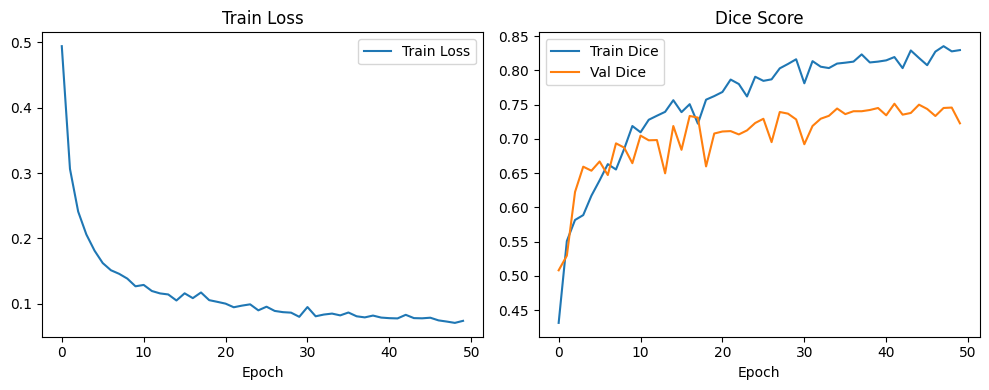

In [47]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_dice"], label="Train Dice")
plt.plot(history["val_dice"], label="Val Dice")
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

5. Inferencia

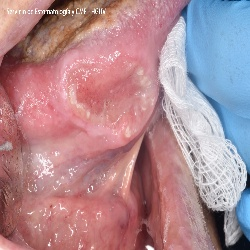

In [72]:
image_path = "/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles/00033C/images/00033C.jpg"
image = Image.open(image_path).convert("RGB")
image

In [61]:
image_size=512
pixel_values = image_processor(image, return_tensors="pt", size=(image_size, image_size)).pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [50]:
import torch

with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [51]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [52]:
def cancer_palette():
    """Paleta para segmentación binaria: fondo y tumor"""
    return [
        [0, 0, 0],       # 0: fondo - negro
        [255, 0, 0],     # 1: tumor - rojo brillante
    ]

In [53]:
from PIL import Image


predicted_segmentation_map = image_processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=[image.size[::-1]]  
)[0]


predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

print(predicted_segmentation_map.shape) 
print(predicted_segmentation_map)        


(250, 250)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


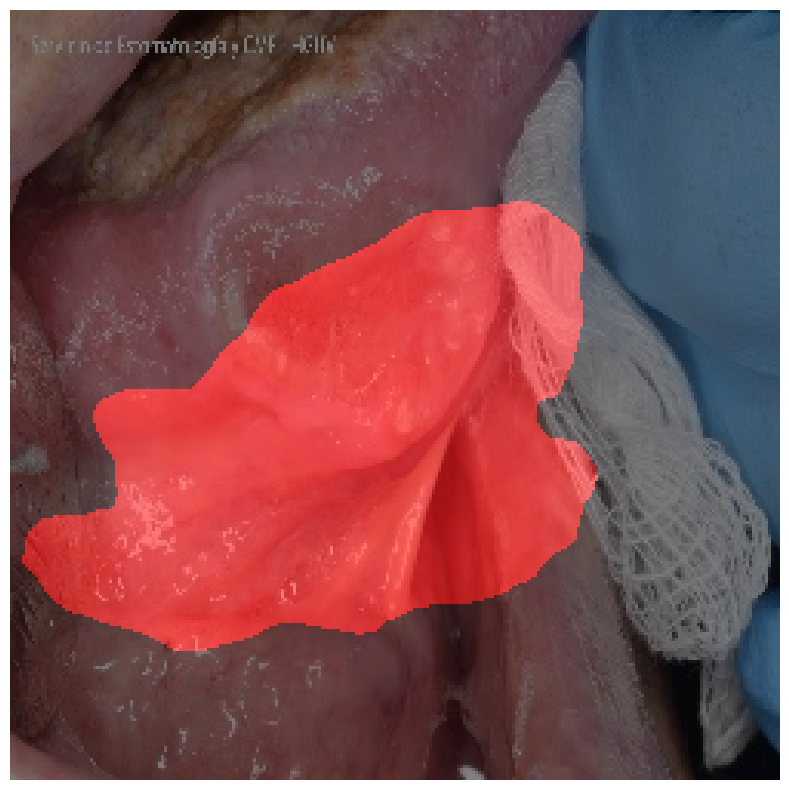

In [73]:
import matplotlib.pyplot as plt
import numpy as np


color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8)

palette = np.array(cancer_palette()) 

for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color

img_np = np.array(image)

blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()

In [55]:
mask_path = '/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles/00069C/masks/00069C_1.jpg'  
mask 

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')

Clases en esta imagen: ['background', 'tumor']


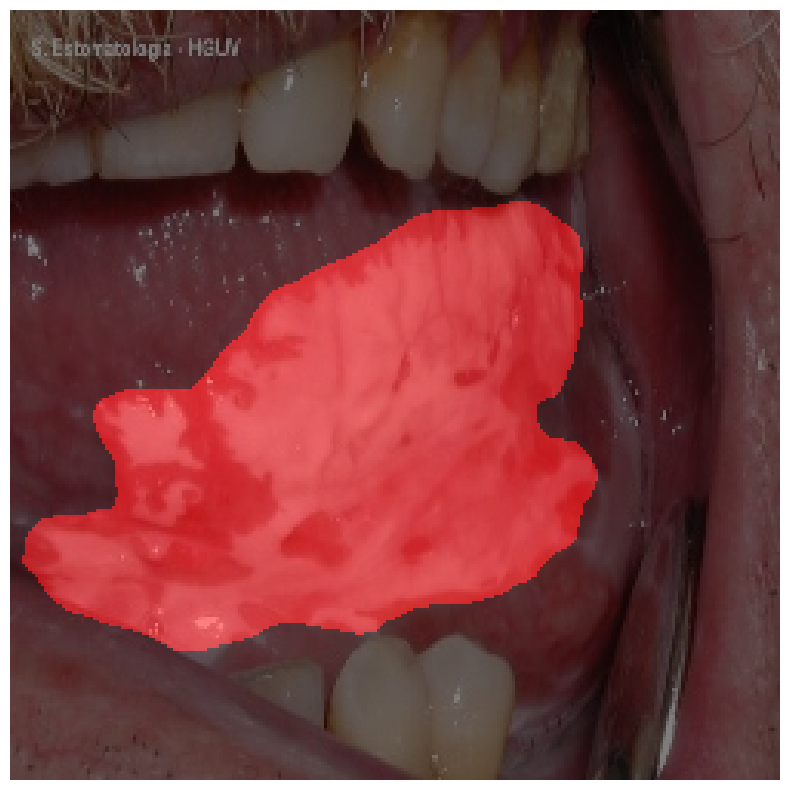

In [56]:
import numpy as np
import matplotlib.pyplot as plt


map = predicted_segmentation_map


classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx in model.config.id2label else None for idx in classes_map]
print("Clases en esta imagen:", unique_classes)

color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8)  
palette = np.array(cancer_palette())

for label, color in enumerate(palette):
    color_seg[map == label] = color


img_np = np.array(image)
blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()

Clases en esta imagen: ['background', 'tumor']


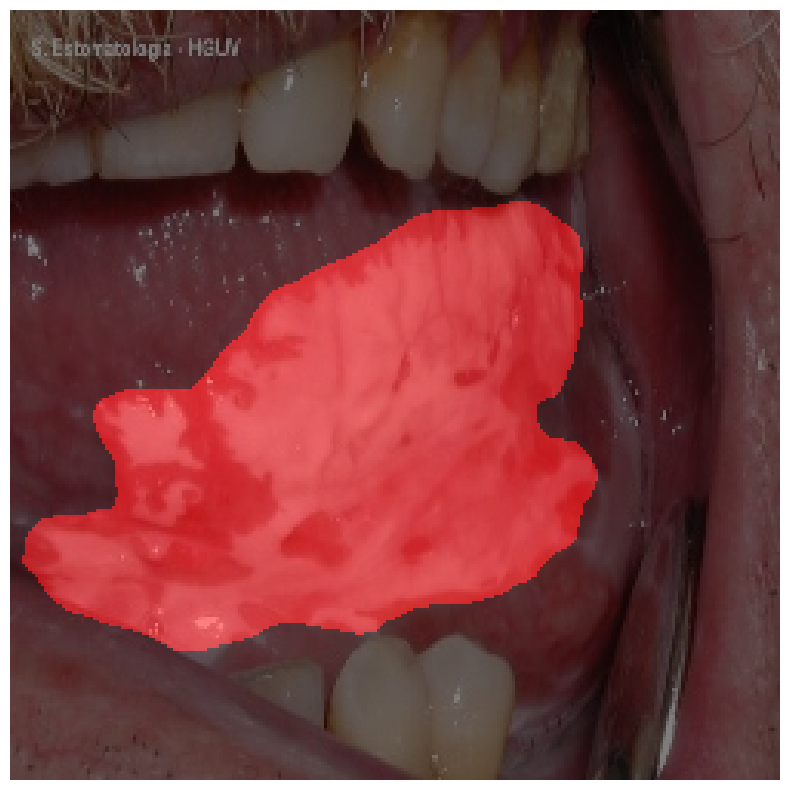

In [57]:
import numpy as np
import matplotlib.pyplot as plt

map = predicted_segmentation_map

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx in model.config.id2label else None for idx in classes_map]
print("Clases en esta imagen:", unique_classes)

color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8)  # altura, ancho, 3 canales
palette = np.array(cancer_palette())

for label, color in enumerate(palette):
    color_seg[map == label] = color


img_np = np.array(image)
blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()